In [1]:
import pandas as pd

df = pd.read_csv('transactions_diy.csv')
df['tr_date'] = pd.to_datetime(df['tr_date'], format='mixed', dayfirst=True)

# Загрузка CSV файла в DataFrame
df = pd.read_csv('transactions_diy.csv')
# Приведение формата даты
df['tr_date'] = pd.to_datetime(df['tr_date'], format='mixed', dayfirst=True)

# Преобразование колонки 'tr_date' в тип datetime
df['tr_date'] = pd.to_datetime(df['tr_date'])

# Вывод первых 5 строк
print("Первые 5 строк:")
print(df.head())

# Вывод основной информации о датасете
print("\nИнформация о датасете:")
print(df.info())

Первые 5 строк:
     tr_date          bcode       client      item  \
0 2017-09-01  code000000001  client13166   sku8444   
1 2017-09-01  code000000001  client13166  sku12545   
2 2017-09-01  code000000001  client13166   sku3391   
3 2017-09-01  code000000001  client13166  sku20444   
4 2017-09-01  code000000002   client1239  sku29959   

                     item_group  quantity  amount  
0              Скобяные изделия         1      29  
1  Оборудование для сада и дачи         1     329  
2                   Инструменты         1     169  
3                   Инструменты         2     578  
4              Скобяные изделия         1     329  

Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008688 entries, 0 to 1008687
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   tr_date     1008688 non-null  datetime64[ns]
 1   bcode       1008688 non-null  object        
 2   client

Агрегация по визитам

Задача: преобразовать транзакции в визиты. На уровне визита суммируются количество и сумма по товарам

Создай функцию aggregate_client_daily_items(df), которая:
1. Группирует транзакции по (client, tr_date, item, item_group)
2. Суммирует quantity и amount для каждой группы
3. Возвращает DataFrame с колонками: client, visit_date, item, item_group, quantity, amount
4. Отсортирован по client, visit_date, item
Комментарий: bcode (номер чека) игнорируем — нас интересует, что клиент купил в день, а не структура чеков.

In [2]:
import pandas as pd

def aggregate_client_daily_items(df):
    """
    Агрегирует транзакции по клиенту, дню, товару и группе.
    Игнорирует bcode (структуру чеков), фокусируется на дневной активности клиента.
    
    Параметры:
        df (pd.DataFrame): исходные транзакции с колонками, включая:
            client, tr_date, item, item_group, quantity, amount, (bcode - игнорируется)
    
    Возвращает:
        pd.DataFrame: агрегированные данные по визитам с колонками
            client, visit_date, item, item_group, quantity, amount
        отсортирован по client, visit_date, item
    """
    # Убедимся, что tr_date — в формате datetime
    df = df.copy()
    df['tr_date'] = pd.to_datetime(df['tr_date'])
    
    # Извлекаем дату визита (без времени)
    df['visit_date'] = df['tr_date'].dt.date
    
    # Группируем по клиенту, дате, товару и группе
    # Суммируем количество и сумму
    aggregated = (df.groupby(['client', 'visit_date', 'item', 'item_group'], as_index=False)
                  .agg({'quantity': 'sum', 'amount': 'sum'}))
    
    # Сортировка
    result = aggregated.sort_values(['client', 'visit_date', 'item']).reset_index(drop=True)
    
    return result

daily_items = aggregate_client_daily_items(df)
print(daily_items.head())

daily_items = aggregate_client_daily_items(df)

# Вывод размера
print(f"Размер daily_items: {daily_items.shape[0]:,} строк и {daily_items.shape[1]} столбцов")


     client  visit_date      item     item_group  quantity  amount
0   client1  2018-01-22  sku10765  Лаки и краски         1      29
1   client1  2018-01-22  sku13695  Стойматериалы         5    1535
2   client1  2018-01-22  sku29083  Лаки и краски         2     310
3   client1  2018-01-22   sku2954  Лаки и краски         1     399
4  client10  2019-08-05   sku1893    Инструменты         1      79
Размер daily_items: 1,003,083 строк и 6 столбцов


Расчет профиля клиента (период наблюдения)

Задача: на дату актуальности (конец периода наблюдения) рассчитать для каждого клиента его профиль с RFM и дополнительными признаками.

Напиши функцию calculate_client_profile_at_date(visits_df,observation_end_date).
Функция должна:
1. Фильтровать визиты СТРОГО ДО observation_end_date(visit_date < observation_end_date)
Это важно для метода аналогий — нет утечки данных!
2. Для каждого клиента рассчитать RFM признаки:
 - Recency: количество дней между последним визитом и observation_end_date
- Frequency: количество УНИКАЛЬНЫХ ДАТ визитов (не товаров!)
 - Monetary: общая сумма всех покупок
3. Дополнительные признаки:
 - last_visit_date: дата последнего визита
 - total_quantity: общее количество товаров
 - avg_check: средний чек (Monetary / Frequency)
 - total_unique_items: количество уникальных товаров за историю
 - avg_items_per_visit: среднее количество товаров на визит
 - weekend_visits: количество визитов в субботу и воскресенье
 - amount_last_visit: сумма последнего визита
4. Вернуть DataFrame с профилями, отсортированный по client.

In [3]:
import pandas as pd
from datetime import datetime

def calculate_client_profile_at_date(visits_df, observation_end_date):
    """
    Рассчитывает профиль клиента на указанную дату (до observation_end_date невключительно).
    
    Параметры:
        visits_df (pd.DataFrame): датафрейм с колонками
            client, visit_date, item, item_group, quantity, amount
        observation_end_date (str или datetime): дата в формате 'YYYY-MM-DD'
    
    Возвращает:
        pd.DataFrame: профили клиентов с RFM и доп. признаками, отсортированный по client
    """
    # Приводим даты к нужному формату
    obs_date = pd.to_datetime(observation_end_date).date()
    df = visits_df.copy()
    df['visit_date'] = pd.to_datetime(df['visit_date']).dt.date

    # 1. Фильтрация: строго до observation_end_date
    df_filtered = df[df['visit_date'] < obs_date].copy()

    # Все клиенты (включая тех, у кого нет визитов до даты)
    all_clients = pd.DataFrame({'client': df['client'].unique()})

    if df_filtered.empty:
        # Все признаки = 0 или nan
        profile = all_clients.assign(
            Recency=float('nan'),
            Frequency=0,
            Monetary=0.0,
            last_visit_date=pd.NaT,
            total_quantity=0,
            avg_check=0.0,
            total_unique_items=0,
            avg_items_per_visit=0.0,
            weekend_visits=0,
            amount_last_visit=0.0
        )
    else:
        # Преобразуем в datetime для расчёта дней
        df_filtered['visit_date'] = pd.to_datetime(df_filtered['visit_date'])
        
        # Определяем день недели (0=пн, ..., 6=вс)
        df_filtered['weekday'] = df_filtered['visit_date'].dt.weekday
        df_filtered['is_weekend'] = df_filtered['weekday'].isin([5, 6])  # сб=5, вс=6

        # Группируем по клиенту
        profile = df_filtered.groupby('client', as_index=False).agg(
            last_visit_date=('visit_date', 'max'),
            Frequency=('visit_date', 'nunique'),  # кол-во уникальных дат визитов
            Monetary=('amount', 'sum'),
            total_quantity=('quantity', 'sum'),
            total_unique_items=('item', 'nunique'),
            weekend_visits=('is_weekend', 'sum'),
            amount_last_visit=('amount', 'last')  # сумма последнего визита по времени
        )

        # Recency: кол-во дней от последнего визита до observation_end_date
        obs_dt = pd.to_datetime(obs_date)
        profile['Recency'] = (obs_dt - profile['last_visit_date']).dt.days

        # Производные признаки
        profile['avg_check'] = (profile['Monetary'] / profile['Frequency']).fillna(0)
        profile['avg_items_per_visit'] = (profile['total_quantity'] / profile['Frequency']).fillna(0)

        # Объединяем со всеми клиентами (включая тех, кто не попал в filtered)
        profile = all_clients.merge(profile, on='client', how='left')

        # Заполняем пропуски
        fill_na_dict = {
            'Recency': float('nan'),
            'Frequency': 0,
            'Monetary': 0.0,
            'last_visit_date': pd.NaT,
            'total_quantity': 0,
            'avg_check': 0.0,
            'total_unique_items': 0,
            'avg_items_per_visit': 0.0,
            'weekend_visits': 0,
            'amount_last_visit': 0.0
        }
        profile = profile.fillna(fill_na_dict)

    # Сортировка
    return profile.sort_values('client').reset_index(drop=True)

# Пример использования:
profile1 = calculate_client_profile_at_date(daily_items, '2019-09-01')
print(f"Размер профиля: {len(profile1):,} клиентов")
print(profile1.head())


Размер профиля: 42,746 клиентов
        client last_visit_date  Frequency  Monetary  total_quantity  \
0      client1      2018-01-22        1.0    2273.0             9.0   
1     client10      2019-08-05        1.0    4757.0             3.0   
2    client100      2019-05-08        1.0    7299.0             1.0   
3   client1000      2019-08-24       12.0   31792.0           151.0   
4  client10000      2018-08-01        1.0    8495.0             5.0   

   total_unique_items  weekend_visits  amount_last_visit  Recency  \
0                 4.0             0.0              399.0    587.0   
1                 3.0             0.0             4599.0     27.0   
2                 1.0             0.0             7299.0    116.0   
3                28.0            12.0             1359.0      8.0   
4                 5.0             0.0              799.0    396.0   

     avg_check  avg_items_per_visit  
0  2273.000000             9.000000  
1  4757.000000             3.000000  
2  7299.0000

Разметка события (период результата)

Задача: определить, посещал ли клиент магазин в заданный период [result_start, result_end) (period [2019-09-01, 2019-10-01))

Напиши функцию mark_events(visits_df, result_start_date, result_end_date).
Функция должна:
1. Получить уникальный список всех client из visits_df
2. Фильтровать визиты в СТРОГОМ диапазоне: visit_date >= result_start_date И visit_date < result_end_date
3. Определить, какие клиенты имели хотя бы один визит в этот период
4. Вернуть DataFrame с двумя колонками:
 - client: все уникальные клиенты
 - event: True если клиент посетил магазин в период, иначе False
 
Важно: это ТОЛЬКО разметка события, без признаков!

In [4]:
import pandas as pd

def mark_events(visits_df, result_start_date, result_end_date):
    """
    Размечает, посещал ли клиент магазин в заданном периоде [start, end).
    
    Параметры:
        visits_df (pd.DataFrame): датафрейм с колонками 'client', 'visit_date'
        result_start_date (str): начало периода (включительно), например '2019-09-01'
        result_end_date (str): конец периода (исключительно), например '2019-10-01'
    
    Возвращает:
        pd.DataFrame: с колонками
            - client: все уникальные клиенты
            - event: True — был визит в периоде, иначе False
    """
    # Приводим даты к формату date
    start_dt = pd.to_datetime(result_start_date).date()
    end_dt = pd.to_datetime(result_end_date).date()

    # Работаем с копией, чтобы не изменять оригинал
    df = visits_df.copy()
    df['visit_date'] = pd.to_datetime(df['visit_date']).dt.date

    # 1. Все уникальные клиенты
    all_clients = pd.DataFrame({'client': df['client'].unique()})

    # 2. Фильтрация: строго в диапазоне [start_dt, end_dt)
    filtered = df[
        (df['visit_date'] >= start_dt) &
        (df['visit_date'] < end_dt)
    ]

    # 3. Клиенты, имевшие хотя бы один визит
    clients_in_period = filtered['client'].unique()

    # 4. Размечаем всех клиентов
    all_clients['event'] = all_clients['client'].isin(clients_in_period)

    # Сортировка по client
    return all_clients.sort_values('client').reset_index(drop=True)

# Пример использования:
events_df = mark_events(daily_items, '2019-09-01', '2019-10-01')
print(f"Общее число клиентов: {len(events_df):,}")
print(f"Вернулись в сентябре: {events_df['event'].sum():,} ({events_df['event'].mean():.1%})")


Общее число клиентов: 42,746
Вернулись в сентябре: 8,821 (20.6%)


Это чистая разметка — без признаков, только событие.
Совместима с profile_df — можно объединять.
Гарантирует отсутствие утечки данных.
Теперь у вас:
profile_df — признаки до 2019-09-01
events_df — событие в сентябре

Объединение профиля и события в выборку

Задача: соединить профили клиентов с разметкой события в единую выборку.

Напиши функцию create_training_sample(profile_df, events_df).
Функция должна:
1. Выполнить inner join профиля и событий по 'client’ (оставляем только клиентов, которые есть в обоих датафреймах)
2. Проверить, что целевая переменная 'event' не содержит пропусков
3. Удалить служебные колонки с датами (они не нужны для моделирования)
4. Убедиться что в выборке есть оба класса для события (True и False)
5. Вернуть готовую выборку
На выходе: DataFrame где каждая строка = (профиль клиента + событие).

Признаки: ['client', 'Recency', 'Frequency',
'Monetary', 'total_quantity', 'avg_check',
'total_unique_items', 'avg_items_per_visit',
'weekend_visits', 'amount_last_visit', 'event'] + добавь признак "Относительная ценность клиента" (сумма покупок одного клиента/максимальную сумму покупок среди всех клиентов)

In [7]:
def create_training_sample(profile_df, events_df):
    """
    Создаёт обучающую выборку, объединяя профили и события.
    
    Параметры:
        profile_df (pd.DataFrame): признаки клиентов (результат calculate_client_profile_at_date)
        events_df (pd.DataFrame): разметка события (результат mark_events)
    
    Возвращает:
        pd.DataFrame: готовая выборка с признаками и целевой переменной 'event'
    """
    # 1. Inner join по 'client' — только клиенты, присутствующие в обоих датафреймах
    merged = profile_df.merge(events_df, on='client', how='inner')
    
    if merged.empty:
        raise ValueError("Объединение вернуло пустой DataFrame. Проверьте, есть ли общие клиенты.")
    
    # 2. Проверка: нет ли пропусков в 'event'
    if merged['event'].isnull().any():
        raise ValueError(f"Целевая переменная 'event' содержит {merged['event'].isnull().sum()} пропусков.")
    
    # 3. Удаление служебных колонок (не используются в модели)
    cols_to_drop = ['last_visit_date']  # можно расширить при необходимости
    cols_existing = [col for col in cols_to_drop if col in merged.columns]
    if cols_existing:
        merged = merged.drop(columns=cols_existing)
    
    # 4. Проверка: оба класса присутствуют (True и False)
    if merged['event'].nunique() < 2:
        only_class = merged['event'].iloc[0] if len(merged) > 0 else None
        raise ValueError(f"В выборке только один класс: {only_class}. Невозможно обучить модель.")
    
    # 5. Добавление нового признака: Относительная ценность клиента
    max_monetary = merged['Monetary'].max()
    if max_monetary > 0:
        merged['relative_value_pct'] = (merged['Monetary'] / max_monetary) * 100
    else:
        merged['relative_value_pct'] = 0.0
    
    # Выбор финальных признаков (включая новый)
    feature_columns = [
        'client',
        'Recency',
        'Frequency',
        'Monetary',
        'total_quantity',
        'avg_check',
        'total_unique_items',
        'avg_items_per_visit',
        'weekend_visits',
        'amount_last_visit',
        'relative_value_pct',
        'event'
    ]
    
    # Проверим, что все колонки существуют
    missing_cols = [col for col in feature_columns if col not in merged.columns]
    if missing_cols:
        raise ValueError(f"Отсутствуют колонки: {missing_cols}")
    
    result = merged[feature_columns].sort_values('client').reset_index(drop=True)
    
    # Логирование
    print(f"Обучающая выборка создана: {len(result):,} строк")
    print(f"Распределение event: {dict(result['event'].value_counts().sort_index())}")
    
    return result


# 1. Убедитесь, что df загружен
df = pd.read_csv('transactions_diy.csv')
df['tr_date'] = pd.to_datetime(df['tr_date'], format='mixed', dayfirst=True)

# 2. Создаём daily_items (агрегация по визитам)
daily_items = aggregate_client_daily_items(df)
print(f"daily_items создан: {len(daily_items):,} строк")

# 3. Рассчитываем профиль на 2019-09-01
profile_df = calculate_client_profile_at_date(daily_items, '2019-09-01')
print(f"profile_df создан: {len(profile_df):,} клиентов")

# 4. Размечаем событие: [2019-09-01, 2019-10-01)
events_df = mark_events(daily_items, '2019-09-01', '2019-10-01')
print(f"events_df создан: {len(events_df):,} клиентов")

# 5. Создаём обучающую выборку
train_sample = create_training_sample(profile_df, events_df)
print(f"train_sample создан: {len(train_sample):,} строк")
print(train_sample.head())

daily_items создан: 1,003,083 строк
profile_df создан: 42,746 клиентов
events_df создан: 42,746 клиентов
Обучающая выборка создана: 42,746 строк
Распределение event: {False: np.int64(33925), True: np.int64(8821)}
train_sample создан: 42,746 строк
        client  Recency  Frequency  Monetary  total_quantity    avg_check  \
0      client1    587.0        1.0    2273.0             9.0  2273.000000   
1     client10     27.0        1.0    4757.0             3.0  4757.000000   
2    client100    116.0        1.0    7299.0             1.0  7299.000000   
3   client1000      8.0       12.0   31792.0           151.0  2649.333333   
4  client10000    396.0        1.0    8495.0             5.0  8495.000000   

   total_unique_items  avg_items_per_visit  weekend_visits  amount_last_visit  \
0                 4.0             9.000000             0.0              399.0   
1                 3.0             3.000000             0.0             4599.0   
2                 1.0             1.000000     

In [8]:
import pandas as pd

def create_training_sample(profile_df, events_df):
    """
    Создаёт обучающую выборку, объединяя профили и события.
    
    Параметры:
        profile_df (pd.DataFrame): признаки клиентов (результат calculate_client_profile_at_date)
        events_df (pd.DataFrame): разметка события (результат mark_events)
    
    Возвращает:
        pd.DataFrame: готовая выборка с признаками и целевой переменной 'event'
    """
    # 1. Inner join по 'client' — только клиенты, присутствующие в обоих датафреймах
    merged = profile_df.merge(events_df, on='client', how='inner')
    
    if merged.empty:
        raise ValueError("Объединение вернуло пустой DataFrame. Проверьте, есть ли общие клиенты.")
    
    # 2. Проверка: нет ли пропусков в 'event'
    if merged['event'].isnull().any():
        raise ValueError(f"Целевая переменная 'event' содержит {merged['event'].isnull().sum()} пропусков.")
    
    # 3. Удаление служебных колонок (не используются в модели)
    cols_to_drop = ['last_visit_date']  # можно расширить при необходимости
    cols_existing = [col for col in cols_to_drop if col in merged.columns]
    if cols_existing:
        merged = merged.drop(columns=cols_existing)
    
    # 4. Проверка: оба класса присутствуют (True и False)
    if merged['event'].nunique() < 2:
        only_class = merged['event'].iloc[0] if len(merged) > 0 else None
        raise ValueError(f"В выборке только один класс: {only_class}. Невозможно обучить модель.")
    
    # 5. Добавление нового признака: Относительная ценность клиента
    # = (Monetary / max(Monetary)) * 100 (% от максимальной суммы)
    max_monetary = merged['Monetary'].max()
    if max_monetary > 0:
        merged['relative_value_pct'] = (merged['Monetary'] / max_monetary) * 100
    else:
        merged['relative_value_pct'] = 0.0
    
    # Выбор финальных признаков (включая новый)
    feature_columns = [
        'client',
        'Recency',
        'Frequency',
        'Monetary',
        'total_quantity',
        'avg_check',
        'total_unique_items',
        'avg_items_per_visit',
        'weekend_visits',
        'amount_last_visit',
        'relative_value_pct',  # новый признак
        'event'
    ]
    
    # Проверим, что все колонки существуют
    missing_cols = [col for col in feature_columns if col not in merged.columns]
    if missing_cols:
        raise ValueError(f"Отсутствуют колонки: {missing_cols}")
    
    result = merged[feature_columns].sort_values('client').reset_index(drop=True)
    
    # Логирование
    print(f"Обучающая выборка создана: {len(result):,} строк")
    print(f"Распределение event: {dict(result['event'].value_counts().sort_index())}")
    
    return result

# Пример использования:
train_sample = create_training_sample(profile_df, events_df)
print(train_sample.head())


Обучающая выборка создана: 42,746 строк
Распределение event: {False: np.int64(33925), True: np.int64(8821)}
        client  Recency  Frequency  Monetary  total_quantity    avg_check  \
0      client1    587.0        1.0    2273.0             9.0  2273.000000   
1     client10     27.0        1.0    4757.0             3.0  4757.000000   
2    client100    116.0        1.0    7299.0             1.0  7299.000000   
3   client1000      8.0       12.0   31792.0           151.0  2649.333333   
4  client10000    396.0        1.0    8495.0             5.0  8495.000000   

   total_unique_items  avg_items_per_visit  weekend_visits  amount_last_visit  \
0                 4.0             9.000000             0.0              399.0   
1                 3.0             3.000000             0.0             4599.0   
2                 1.0             1.000000             0.0             7299.0   
3                28.0            12.583333            12.0             1359.0   
4                 5.0   

Создание второй выборки (тестовой)

Задача: повторить этапы 2-4 с другими датами для создания тестовой выборки.

Используя те же функции, создай вторую
выборку:
- Профиль на дату: '2019-10-01'
- События в периоде: ['2019-10-01', '2019-11-01')
Сохрани результаты в датафреймы profile2, events2, test_data.

In [9]:
# 1. Профиль на дату: СТРОГО до '2019-10-01' (visit_date < '2019-10-01')
profile2 = calculate_client_profile_at_date(daily_items, '2019-10-01')
print(f"profile2 создан: {len(profile2):,} клиентов")

# 2. События в периоде: [2019-10-01, 2019-11-01)
events2 = mark_events(daily_items, '2019-10-01', '2019-11-01')
print(f"events2 создан: {len(events2):,} клиентов")
print(f"Вернулись в октябре: {events2['event'].sum():,} ({events2['event'].mean():.1%})")

# 3. Тестовая выборка
test_data = create_training_sample(profile2, events2)
print(f"test_data (тестовая выборка) создана: {len(test_data):,} строк")
print(f"Распределение event: {dict(test_data['event'].value_counts().sort_index())}")

profile2 создан: 42,746 клиентов
events2 создан: 42,746 клиентов
Вернулись в октябре: 9,324 (21.8%)
Обучающая выборка создана: 42,746 строк
Распределение event: {False: np.int64(33422), True: np.int64(9324)}
test_data (тестовая выборка) создана: 42,746 строк
Распределение event: {False: np.int64(33422), True: np.int64(9324)}


In [10]:
print("\nПервые строки test_data:")
print(test_data.head())


Первые строки test_data:
        client  Recency  Frequency  Monetary  total_quantity    avg_check  \
0      client1    617.0        1.0    2273.0             9.0  2273.000000   
1     client10     57.0        1.0    4757.0             3.0  4757.000000   
2    client100    146.0        1.0    7299.0             1.0  7299.000000   
3   client1000     17.0       13.0   36495.0           166.0  2807.307692   
4  client10000    426.0        1.0    8495.0             5.0  8495.000000   

   total_unique_items  avg_items_per_visit  weekend_visits  amount_last_visit  \
0                 4.0             9.000000             0.0              399.0   
1                 3.0             3.000000             0.0             4599.0   
2                 1.0             1.000000             0.0             7299.0   
3                31.0            12.769231            16.0             2250.0   
4                 5.0             5.000000             0.0              799.0   

   relative_value_pct  e

Теперь у вас есть:
profile2 — признаки до 2019-10-01
events2 — событие в октябре
test_data — тестовая выборка для валидации модели

Сохранение промежуточных результатов

Задача: сохранить выборки в csv-файлы.

Сохрани обучающую и тестовую выборки в csvфайлы
Файлы, которые появятся в папке:
▪ train_sample.csv — датасет для обучения модели
▪ test_sample.csv — датасет для тестирования модели

In [11]:
# Сохранение обучающей выборки
train_sample.to_csv('train_sample.csv', index=False)
print(f"Обучающая выборка сохранена: train_sample.csv ({len(train_sample):,} строк)")

# Сохранение тестовой выборки
test_data.to_csv('test_sample.csv', index=False)
print(f"Тестовая выборка сохранена: test_sample.csv ({len(test_data):,} строк)")

# Проверка: какие файлы созданы
import os
print("\nФайлы в текущей папке:")
for file in os.listdir():
    if file in ['train_sample.csv', 'test_sample.csv']:
        size = os.path.getsize(file) // 1024
        print(f"   {file} — {size} KB")


Обучающая выборка сохранена: train_sample.csv (42,746 строк)
Тестовая выборка сохранена: test_sample.csv (42,746 строк)

Файлы в текущей папке:
   test_sample.csv — 3824 KB
   train_sample.csv — 3769 KB


Загрузка этих файлов в будущем:

train_sample = pd.read_csv('train_sample.csv')
test_sample = pd.read_csv('test_sample.csv')

Оптимальный биннинг

Используя библиотеку optbinning, напишите код на Python, который проводит WoE/IV-анализ и готовит woe-преобразованные выборки: обучающую и тестовую.
1. Загрузите из csv выборки, выгруженные на предыдущем этапе
2. Запустите расчет модели биннинга с настройками, максимально близкими к настройкам в Loginom
3. Проведите анализ Information Value (IV) - найти сильные признаки
4. Выведите таблицы WoE-анализа для топ-5 признаков (по убыванию IV)
5. Нарисуйте WoE-диаграммы для них
6. Трансформируйте начальные выборки в WoE-значения (не номер бина, как в делалось в Loginom, а значение WoE)
7. Выгрузить в CSV - train_woe.csv и test_woe.csv.

In [12]:
import pandas as pd

# Загрузка обучающей выборки
train_sample = pd.read_csv('train_sample.csv')
print(f"train_sample загружен: {len(train_sample):,} строк")

# Загрузка тестовой выборки
test_sample = pd.read_csv('test_sample.csv')
print(f"test_sample загружен: {len(test_sample):,} строк")

# Просмотр первых строк
print("\nПервые строки train_sample:")
print(train_sample.head())

print("\nПервые строки test_sample:")
print(test_sample.head())

expected_columns = [
    'client', 'Recency', 'Frequency', 'Monetary', 'total_quantity',
    'avg_check', 'total_unique_items', 'avg_items_per_visit',
    'weekend_visits', 'amount_last_visit', 'relative_value_pct', 'event'
]

print("Все ожидаемые колонки присутствуют в train_sample:" , 
      set(expected_columns).issubset(train_sample.columns))

print("Все ожидаемые колонки присутствуют в test_sample:" , 
      set(expected_columns).issubset(test_sample.columns))


train_sample загружен: 42,746 строк
test_sample загружен: 42,746 строк

Первые строки train_sample:
        client  Recency  Frequency  Monetary  total_quantity    avg_check  \
0      client1    587.0        1.0    2273.0             9.0  2273.000000   
1     client10     27.0        1.0    4757.0             3.0  4757.000000   
2    client100    116.0        1.0    7299.0             1.0  7299.000000   
3   client1000      8.0       12.0   31792.0           151.0  2649.333333   
4  client10000    396.0        1.0    8495.0             5.0  8495.000000   

   total_unique_items  avg_items_per_visit  weekend_visits  amount_last_visit  \
0                 4.0             9.000000             0.0              399.0   
1                 3.0             3.000000             0.0             4599.0   
2                 1.0             1.000000             0.0             7299.0   
3                28.0            12.583333            12.0             1359.0   
4                 5.0           

In [13]:
import pandas as pd

# Загружаем обучающую выборку
train_sample = pd.read_csv('train_sample.csv')
print(f"train_sample загружен: {len(train_sample):,} строк")

# Проверим типы и наличие client/event
print("\nПервая строка:")
print(train_sample.iloc[0])

train_sample загружен: 42,746 строк

Первая строка:
client                  client1
Recency                   587.0
Frequency                   1.0
Monetary                 2273.0
total_quantity              9.0
avg_check                2273.0
total_unique_items          4.0
avg_items_per_visit         9.0
weekend_visits              0.0
amount_last_visit         399.0
relative_value_pct     0.058472
event                     False
Name: 0, dtype: object


In [24]:
# Удаляем client, оставляем только признаки
X_train = train_sample.drop(columns=['client', 'event'])

# Целевая переменная
y_train = train_sample['event'].astype(int)  # преобразуем bool → int (0/1)

# Оставляем только числовые признаки (на случай, если есть нечисловые)
X_train = X_train.select_dtypes(include='number')

print(f"X_train: {X_train.shape[1]} признаков, {len(X_train):,} строк")
print(f"y_train: {len(y_train):,} значений")
print("\nПризнаки для биннинга:")
print(X_train.columns.tolist())

# === 1. Подготовка обучающей выборки ===
X_train = train_sample.drop(columns=['client', 'event'])
y_train = train_sample['event'].astype(int)

# Оставляем только числовые признаки
X_train = X_train.select_dtypes(include='number')

# Запоминаем колонки и порядок — это и есть "эталон"
X_train_clean = X_train.copy()

# Заполняем пропуски (пример)
fill_values = {
    'Recency': 999,
    'Frequency': 0,
    'Monetary': 0,
    'total_quantity': 0,
    'avg_check': 0,
    'total_unique_items': 0,
    'avg_items_per_visit': 0,
    'weekend_visits': 0,
    'amount_last_visit': 0,
    'relative_value_pct': 0
}

X_train_clean = X_train_clean.fillna(fill_values)

# Сохраните fill_values, чтобы использовать потом на тесте
import joblib
joblib.dump(fill_values, 'fill_values.pkl')  # для инференса



X_train: 10 признаков, 42,746 строк
y_train: 42,746 значений

Признаки для биннинга:
['Recency', 'Frequency', 'Monetary', 'total_quantity', 'avg_check', 'total_unique_items', 'avg_items_per_visit', 'weekend_visits', 'amount_last_visit', 'relative_value_pct']


['fill_values.pkl']

In [15]:
# Проверка пропусков
missing = X_train.isnull().sum()
if missing.sum() > 0:
    print("\nПропуски в признаках:")
    print(missing[missing > 0])
else:
    print("\nНет пропусков в признаках")

# Проверка на бесконечности
inf_count = X_train.isin([float('inf'), -float('inf')]).sum().sum()
if inf_count > 0:
    print(f"Найдено {inf_count} бесконечных значений")
else:
    print("Нет бесконечных значений")



Пропуски в признаках:
Recency    2840
dtype: int64
Нет бесконечных значений


In [16]:
from optbinning import BinningProcess

# Выберем признаки для биннинга
features = X_train.columns.tolist()

# Создаём процесс биннинга
binning_process = BinningProcess(
    variable_names=features,
    max_n_prebins=10,
    min_prebin_size=0.02,
    min_n_bins=2,
    max_n_bins=10,
    selection_criteria={"iv": {"min": 0.01}}  # отберём информативные
)

# Обучаем
binning_process.fit(X_train, y_train)

# Получаем IV (Information Value)
iv_summary = binning_process.summary().sort_values(by='iv', ascending=False)

# Добавим ранг
iv_summary['rank'] = range(1, len(iv_summary) + 1)

# Красивый вывод IV
print("📊 Information Value (IV) — топ признаков (по убыванию):")
display(
    iv_summary[['rank', 'name', 'iv']]
    .round(4)
    .style
    .background_gradient(cmap='Blues', subset=['iv'], low=0.5)  # чем выше IV — тем темнее
    .format({'iv': '{:.4f}'})
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('font-weight', 'bold')]},
        {'selector': 'td', 'props': [('text-align', 'center')]}
    ])
    .set_caption("Таблица IV: рейтинг признаков по информативности")
    .set_properties(**{'border': '1px solid darkblue', 'padding': '5px'})
)

📊 Information Value (IV) — топ признаков (по убыванию):


,rank,name,iv
0,1,Recency,1.2018
1,2,Frequency,0.8956
5,3,total_unique_items,0.6848
3,4,total_quantity,0.6612
2,5,Monetary,0.5640
9,6,relative_value_pct,0.5640
7,7,weekend_visits,0.2453
6,8,avg_items_per_visit,0.2307
4,9,avg_check,0.1536
8,10,amount_last_visit,0.1424


Выведи таблицы WoE для топ-5 признаков

In [21]:
print("WOE-ТАБЛИЦЫ ДЛЯ ТОП-5 ПРИЗНАКОВ (первые 5 строк + итог)")
# Пример: получение важности признаков из модели
# (предполагается, что у вас уже есть обученная модель и X_train)

# Если вы использовали RandomForest, CatBoost и т.п.:
import numpy as np

# Убедитесь, что model уже обучен, и X_train — это DataFrame с признаками
try:
    # Получаем важность признаков
    importances = model.feature_importances_
    feature_names = X_train.columns  # должен быть без 'client', 'event'

    # Создаём таблицу важности
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    # Берём топ-5 признаков
    top5_features = feature_importance_df['feature'].head(5).tolist()

    print("Топ-5 признаков по важности:")
    print(feature_importance_df.head(5))

except Exception as e:
    print("Ошибка при получении важности признаков:", e)
    # Резервный вариант — указать вручную (для теста)
    top5_features = ['Recency', 'Frequency', 'Monetary', 'avg_check', 'total_quantity']

for feature in top5_features:
    print(f"\n{feature.upper()}")
    print("-" * 40)
    
    try:
        # Получаем таблицу биннинга
        optb = binning_process.get_binned_variable(feature)
        table = optb.binning_table.build()
        
        # Выводим первые 5 строк + последняя строка (Totals)
        display(table.head(5).round(4))
        display(table.tail(1).round(4))  # Totals
    
    except Exception as e:
        print(f"Ошибка: {e}")

WOE-ТАБЛИЦЫ ДЛЯ ТОП-5 ПРИЗНАКОВ (первые 5 строк + итог)
Ошибка при получении важности признаков: name 'model' is not defined

RECENCY
----------------------------------------


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",963,0.0225,351,612,0.6355,-1.902963,0.1123,0.0122
1,"[2.50, 7.50)",1931,0.0452,890,1041,0.5391,-1.503733,0.1380,0.0158
2,"[7.50, 19.50)",3680,0.0861,2143,1537,0.4177,-1.014643,0.1127,0.0135
3,"[19.50, 36.50)",3600,0.0842,2417,1183,0.3286,-0.632543,0.0398,0.0049
4,"[36.50, 60.50)",3515,0.0822,2700,815,0.2319,-0.149198,0.0019,0.0002


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
Totals,,42746,1.0,33925,8821,0.2064,,1.2018,0.1351



FREQUENCY
----------------------------------------


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",2840,0.0664,1550,1290,0.4542,-1.163404,0.1170,0.0139
1,"[0.50, 1.50)",12308,0.2879,11523,785,0.0638,1.3394,0.3357,0.0391
2,"[1.50, 3.50)",10216,0.2390,9004,1212,0.1186,0.65838,0.0843,0.0103
3,"[3.50, 4.50)",2929,0.0685,2414,515,0.1758,0.197857,0.0025,0.0003
4,"[4.50, 6.50)",4080,0.0954,3193,887,0.2174,-0.066146,0.0004,0.0001


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
Totals,,42746,1.0,33925,8821,0.2064,,0.8956,0.1041



MONETARY
----------------------------------------


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.00)",2840,0.0664,1550,1290,0.4542,-1.163404,0.1170,0.0139
1,"[5.00, 1686.50)",7466,0.1747,6917,549,0.0735,1.186622,0.1681,0.0199
2,"[1686.50, 4002.50)",7915,0.1852,6998,917,0.1159,0.685255,0.0701,0.0086
3,"[4002.50, 7308.50)",6542,0.1530,5575,967,0.1478,0.404832,0.0221,0.0027
4,"[7308.50, 11504.50)",5033,0.1177,4090,943,0.1874,0.120217,0.0016,0.0002


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
Totals,,42746,1.0,33925,8821,0.2064,,0.564,0.0672



AVG_CHECK
----------------------------------------


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 5.00)",2840,0.0664,1550,1290,0.4542,-1.163404,0.1170,0.0139
1,"[5.00, 3246.49)",29116,0.6811,23233,5883,0.2021,0.02649,0.0005,0.0001
2,"[3246.49, 5978.17)",6250,0.1462,5192,1058,0.1693,0.243722,0.0081,0.0010
3,"[5978.17, 6773.17)",909,0.0213,774,135,0.1485,0.39928,0.0030,0.0004
4,"[6773.17, inf)",3631,0.0849,3176,455,0.1253,0.596063,0.0251,0.0031


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
Totals,,42746,1.0,33925,8821,0.2064,,0.1536,0.0184



TOTAL_QUANTITY
----------------------------------------


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 0.50)",2840,0.0664,1550,1290,0.4542,-1.163404,0.1170,0.0139
1,"[0.50, 2.50)",4245,0.0993,3975,270,0.0636,1.342341,0.1162,0.0135
2,"[2.50, 8.50)",7761,0.1816,7100,661,0.0852,1.027079,0.1380,0.0165
3,"[8.50, 22.50)",9121,0.2134,7964,1157,0.1269,0.582084,0.0603,0.0074
4,"[22.50, 43.50)",6469,0.1513,5217,1252,0.1935,0.080163,0.0009,0.0001


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
Totals,,42746,1.0,33925,8821,0.2064,,0.6612,0.0783


Построй диаграммы WoE для этих 5 признаков

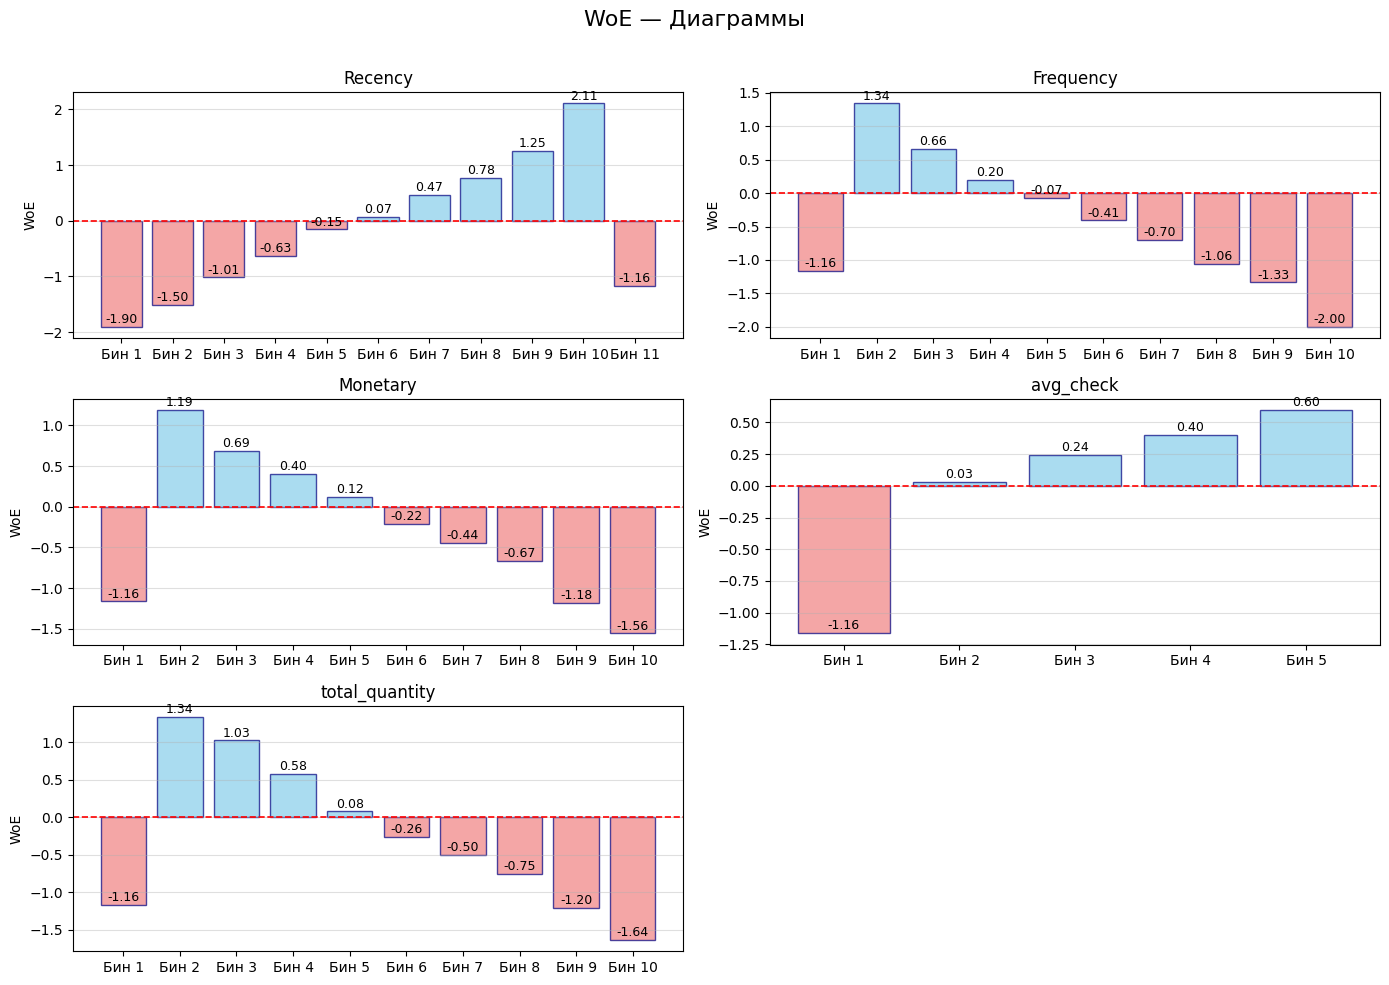

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 2, figsize=(14, 10))
plt.suptitle("WoE — Диаграммы", fontsize=16, y=0.98)
axes = axes.flatten()
axes[-1].set_visible(False)

for i, feature in enumerate(top5_features):
    ax = axes[i]
    
    try:
        optb = binning_process.get_binned_variable(feature)
        table = optb.binning_table.build()
        
        # Убираем строку Totals
        table = table.iloc[:-1]
        
        # Фильтруем: только бины с количеством > 0
        table = table[table['Count'] > 0]
        
        if len(table) == 0:
            ax.text(0.5, 0.5, "Нет данных", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"{feature}")
            continue
        
        # Подписи бинов
        bin_labels = [f"Бин {j+1}" for j in range(len(table))]
        woe_values = table['WoE']
        colors = ['skyblue' if w >= 0 else 'lightcoral' for w in woe_values]

        bars = ax.bar(bin_labels, woe_values, color=colors, edgecolor='navy', alpha=0.7)
        for bar, woe in zip(bars, woe_values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
                    f"{woe:.2f}", ha='center', va='bottom', fontsize=9)

        ax.set_title(f"{feature}")
        ax.set_ylabel("WoE")
        ax.axhline(0, color='red', linestyle='--', linewidth=1.2)
        ax.grid(True, axis='y', alpha=0.4)

    except Exception as e:
        ax.text(0.5, 0.5, f"Ошибка\n{str(e)[:30]}", ha='center', va='center',
                fontsize=10, color='red', transform=ax.transAxes)
        ax.set_title(f"{feature}")

plt.tight_layout(rect=[0, 0, 1, 0.97])



Трансформируй X_train и X_test в WoE

In [25]:
# Загружаем test_sample (если ещё не загружен)
test_sample = pd.read_csv('test_sample.csv')
print(f"test_sample загружен: {len(test_sample)} строк")

# Выделяем признаки и целевую переменную
X_test = test_sample.drop(columns=['client', 'event'])
y_test = test_sample['event'].astype(int)

# Приводим к тем же колонкам, что и X_train_clean
X_test = X_test[X_train_clean.columns]  # одинаковый порядок

# Заполняем NaN так же, как для X_train
fill_values = {
    'Recency': 999,
    'Frequency': 0,
    'Monetary': 0,
    'total_quantity': 0,
    'avg_check': 0,
    'total_unique_items': 0,
    'avg_items_per_visit': 0,
    'weekend_visits': 0,
    'amount_last_visit': 0,
    'relative_value_pct': 0
}

X_test_clean = X_test.fillna(fill_values)
print(f"X_test_clean создан: {len(X_test_clean)} строк, пропусков: {X_test_clean.isnull().sum().sum()}")

# Трансформируем X_train и X_test в WoE
X_train_woe = binning_process.transform(X_train_clean, metric="woe")
X_test_woe = binning_process.transform(X_test_clean, metric="woe")

print(f"X_train_woe: {X_train_woe.shape}")
print(f"X_test_woe: {X_test_woe.shape}")

# Проверим: нет ли NaN в WoE?
print("Пропусков в X_train_woe:", pd.isna(X_train_woe).sum().sum())
print("Пропусков в X_test_woe:", pd.isna(X_test_woe).sum().sum())

# Трансформация + правильное объединение

# 1. Убедимся, что X_train_clean и y_train — из одного и того же train_sample
X_train_clean = train_sample.drop(columns=['client', 'event']).copy()
X_train_clean = X_train_clean.fillna(fill_values)  # как вы определили ранее

# 2. Преобразуем в WoE
X_train_woe = binning_process.transform(X_train_clean, metric="woe")

# 3. Преобразуем обратно в DataFrame с правильными именами столбцов
X_train_woe = pd.DataFrame(X_train_woe, columns=X_train_clean.columns)

# 4. Добавляем обратно client и event — С ТОЙ ЖЕ ВЫБОРКИ, что и X_train_clean
X_train_woe['client'] = train_sample['client'].values
X_train_woe['event'] = train_sample['event'].values

# 5. Переставим столбцы: client и event — в начало
cols = ['client', 'event'] + [col for col in X_train_woe.columns if col not in ['client', 'event']]
X_train_woe = X_train_woe[cols]

print(f" X_train_woe успешно создан: {len(X_train_woe)} строк")
print(f"   Признаки: {list(X_train_woe.columns)}")

#Для тестовой выборки

X_test_clean = test_sample.drop(columns=['client', 'event']).copy()
X_test_clean = X_test_clean.fillna(fill_values)

X_test_woe = binning_process.transform(X_test_clean, metric="woe")
X_test_woe = pd.DataFrame(X_test_woe, columns=X_test_clean.columns)

X_test_woe['client'] = test_sample['client'].values
X_test_woe['event'] = test_sample['event'].values

cols = ['client', 'event'] + [col for col in X_test_woe.columns if col not in ['client', 'event']]
X_test_woe = X_test_woe[cols]

print(f" X_test_woe успешно создан: {len(X_test_woe)} строк")




test_sample загружен: 42746 строк
X_test_clean создан: 42746 строк, пропусков: 0
X_train_woe: (42746, 10)
X_test_woe: (42746, 10)
Пропусков в X_train_woe: 0
Пропусков в X_test_woe: 0
 X_train_woe успешно создан: 42746 строк
   Признаки: ['client', 'event', 'Recency', 'Frequency', 'Monetary', 'total_quantity', 'avg_check', 'total_unique_items', 'avg_items_per_visit', 'weekend_visits', 'amount_last_visit', 'relative_value_pct']
 X_test_woe успешно создан: 42746 строк


Дополните ваш код следующими двумя блоками

import pickle
# binning_process уже обучен на X_train, y_train
with open("binning_process.pkl", "wb") as f:
pickle.dump(binning_process, f)

with open("binning_process.pkl", "rb") as f:
binning_process_loaded = pickle.load(f)
# Теперь можем использовать загруженную модель
X_new_woe =
binning_process_loaded.transform(X_new)

зачем?


In [26]:
import pickle

# Сохраняем обученный binning_process
with open("binning_process.pkl", "wb") as f:
    pickle.dump(binning_process, f)

print("binning_process сохранён в 'binning_process.pkl'")

# Загружаем binning_process из файла
with open("binning_process.pkl", "rb") as f:
    binning_process_loaded = pickle.load(f)

print("binning_process загружен из файла")
print(f"   Статус: {type(binning_process_loaded)}")

# Возьмём несколько строк из X_train_clean как "новые данные"
X_new = X_train_clean.iloc[:5].copy()
print("Новые данные (X_new):")
print(X_new)

# Применяем загруженный биннинг
X_new_woe = binning_process_loaded.transform(X_new, metric="woe")

print("\nПреобразовано в WoE:")
print(X_new_woe.round(4))

# Проверим для одного признака
feature = 'Recency'

# Оригинальный
optb_orig = binning_process.get_binned_variable(feature)
table_orig = optb_orig.binning_table.build()

# Загруженный
optb_loaded = binning_process_loaded.get_binned_variable(feature)
table_loaded = optb_loaded.binning_table.build()

print(f"Бины совпадают для {feature}:", 
      table_orig[['Bin', 'WoE']].round(6).equals(table_loaded[['Bin', 'WoE']].round(6)))


binning_process сохранён в 'binning_process.pkl'
binning_process загружен из файла
   Статус: <class 'optbinning.binning.binning_process.BinningProcess'>
Новые данные (X_new):
   Recency  Frequency  Monetary  total_quantity    avg_check  \
0    587.0        1.0    2273.0             9.0  2273.000000   
1     27.0        1.0    4757.0             3.0  4757.000000   
2    116.0        1.0    7299.0             1.0  7299.000000   
3      8.0       12.0   31792.0           151.0  2649.333333   
4    396.0        1.0    8495.0             5.0  8495.000000   

   total_unique_items  avg_items_per_visit  weekend_visits  amount_last_visit  \
0                 4.0             9.000000             0.0              399.0   
1                 3.0             3.000000             0.0             4599.0   
2                 1.0             1.000000             0.0             7299.0   
3                28.0            12.583333            12.0             1359.0   
4                 5.0             

Тривиальная логрегрессия только на признаке «Давность» (Recency), с расчетом ROC-AUC метрики и построением ROC-кривой

X_train_rec: (39906, 1)
X_test_rec:  (41196, 1)
AUC (Recency only):
   Обучение: 0.7827
   Тест:     0.7811

 Уравнение логистической регрессии:
   log_odds = -0.9998 × Recency + -1.4583
   вероятность = 1 / (1 + exp(-log_odds))


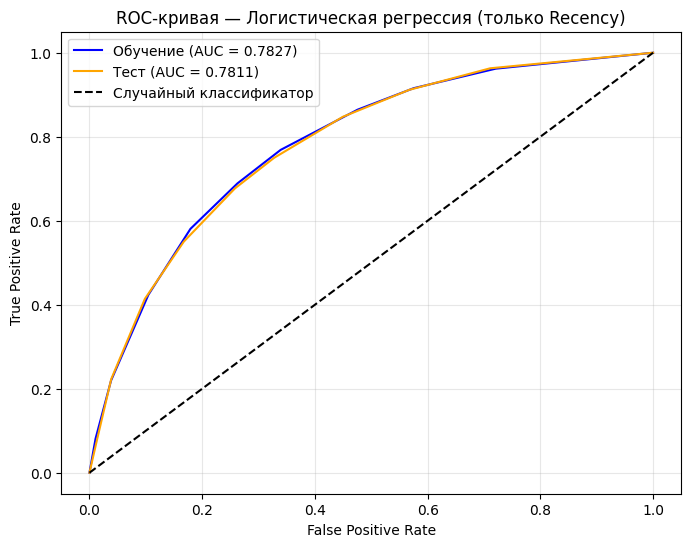

In [27]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Убедимся, что у нас есть train_woe и test_woe
# Если нет — загрузим
try:
    train_woe = pd.read_csv('train_woe.csv')
    test_woe = pd.read_csv('test_woe.csv')
except FileNotFoundError:
    # Если файлов нет — создаём из X_train_woe (если в памяти)
    X_train_woe.to_csv('train_woe.csv', index=False)
    X_test_woe.to_csv('test_woe.csv', index=False)
    train_woe = pd.read_csv('train_woe.csv')
    test_woe = pd.read_csv('test_woe.csv')

# Выбираем только один признак: Recency
X_train_rec = train_woe[['Recency']]  # WoE-значение Recency
y_train_rec = train_woe['event']

X_test_rec = test_woe[['Recency']]
y_test_rec = test_woe['event']

print(f"X_train_rec: {X_train_rec.shape}")
print(f"X_test_rec:  {X_test_rec.shape}")

# Создаём и обучаем модель
model_recency = LogisticRegression()
model_recency.fit(X_train_rec, y_train_rec)

# Предсказания
y_train_pred = model_recency.predict_proba(X_train_rec)[:, 1]
y_test_pred = model_recency.predict_proba(X_test_rec)[:, 1]

# AUC
auc_train = roc_auc_score(y_train_rec, y_train_pred)
auc_test = roc_auc_score(y_test_rec, y_test_pred)

print(f"AUC (Recency only):")
print(f"   Обучение: {auc_train:.4f}")
print(f"   Тест:     {auc_test:.4f}")

intercept = model_recency.intercept_[0]
coef = model_recency.coef_[0][0]

print(f"\n Уравнение логистической регрессии:")
print(f"   log_odds = {coef:.4f} × Recency + {intercept:.4f}")
print(f"   вероятность = 1 / (1 + exp(-log_odds))")

fpr_train, tpr_train, _ = roc_curve(y_train_rec, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test_rec, y_test_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Обучение (AUC = {auc_train:.4f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Тест (AUC = {auc_test:.4f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая — Логистическая регрессия (только Recency)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Анализ взаимосвязей между признаками посредством вычисления корреляционной матрицы

X_woe: 10 признаков
Признаки: ['Recency', 'Frequency', 'Monetary', 'total_quantity', 'avg_check', 'total_unique_items', 'avg_items_per_visit', 'weekend_visits', 'amount_last_visit', 'relative_value_pct']
Корреляционная матрица (первые 5x5):


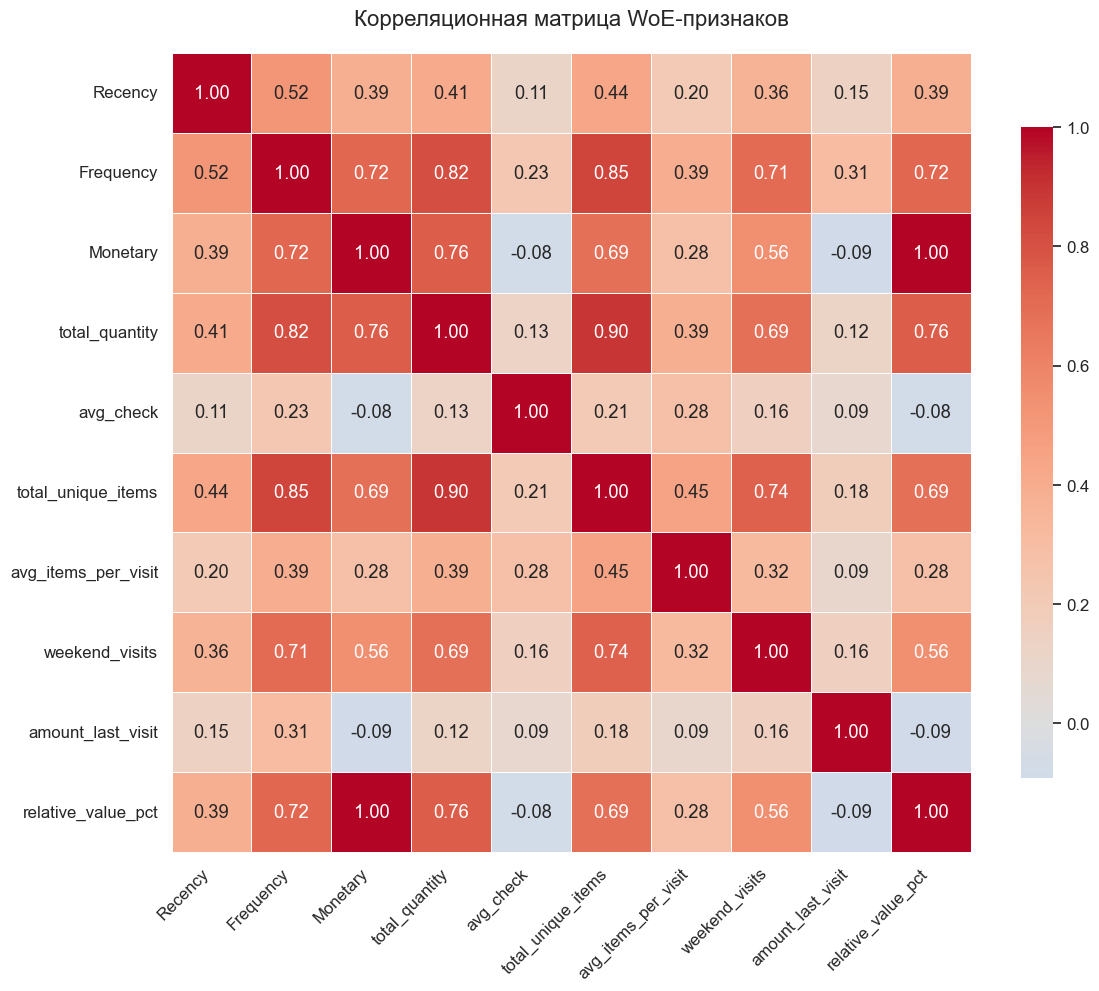

Найдено 10 пар с |корреляция| > 0.7:


,Признак 1,Признак 2,Корреляция
6,Monetary,relative_value_pct,+1.0000
7,total_quantity,total_unique_items,+0.8970
2,Frequency,total_unique_items,+0.8463
1,Frequency,total_quantity,+0.8186
8,total_quantity,relative_value_pct,+0.7573
5,Monetary,total_quantity,+0.7573
9,total_unique_items,weekend_visits,+0.7428
0,Frequency,Monetary,+0.7221
4,Frequency,relative_value_pct,+0.7221
3,Frequency,weekend_visits,+0.7068


In [28]:
import pandas as pd

# Загружаем WoE-данные (если ещё не в памяти)
train_woe = pd.read_csv('train_woe.csv')

# Выбираем только WoE-признаки (числовые, без client и event)
X_woe = train_woe.drop(columns=['client', 'event'])

print(f"X_woe: {X_woe.shape[1]} признаков")
print("Признаки:", X_woe.columns.tolist())

# Матрица парных корреляций Пирсона
corr_matrix = X_woe.corr(method='pearson')

# Округлим для удобства
corr_matrix_rounded = corr_matrix.round(4)

print("Корреляционная матрица (первые 5x5):")
corr_matrix_rounded.head(5).iloc[:, :5]

import seaborn as sns
import matplotlib.pyplot as plt

# Настройка размера и стиля
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.1)

# Тепловая карта
sns.heatmap(
    corr_matrix,
    annot=True,                  # показывать значения
    fmt=".2f",                   # формат: 2 знака после запятой
    cmap='coolwarm',             # цвет: красный — положительная, синий — отрицательная
    center=0,                    # центр на 0
    square=True,                 # квадратные ячейки
    linewidths=0.5,              # линии между ячейками
    cbar_kws={"shrink": 0.8}     # размер шкалы
)

plt.title("Корреляционная матрица WoE-признаков", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Порог высокой корреляции
threshold = 0.7

# Верхний треугольник матрицы (убираем дубли)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > threshold:
            high_corr_pairs.append({
                'Признак 1': corr_matrix.columns[i],
                'Признак 2': corr_matrix.columns[j],
                'Корреляция': corr_val
            })

# Вывод
if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values(by='Корреляция', key=abs, ascending=False)
    print(f"Найдено {len(high_corr_df)} пар с |корреляция| > {threshold}:")
    display(high_corr_df.style.format({'Корреляция': '{:+.4f}'}).background_gradient(cmap='RdYlGn_r', subset=['Корреляция']))
else:
    print(f"Нет пар с |корреляция| > {threshold}")

Полная логрегрессия с L2 регуляризацией на всех доступных признаках

X_train: 10 признаков, 39,906 строк
X_test:  10 признаков,  41,196 строк
 Подбор оптимального C...


C:\Users\alexl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1780: FutureWarning: The default value for l1_ratios will change from None to (0.0,) in version 1.10. From version 1.10 onwards, only array-like with values in [0, 1] will be allowed, None will be forbidden. To avoid this warning, explicitly set a value, e.g. l1_ratios=(0,).
  warnings.warn(
C:\Users\alexl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1811: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratios' instead. Use l1_ratios=(0,) instead of penalty='l2'  and l1_ratios=(1,) instead of penalty='l1'.
  warnings.warn(
C:\Users\alexl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.1

Оптимальное значение C: 0.0336
Качество модели (L2-регуляризованная логрегрессия)
   AUC на обучении: 0.8074
   AUC на тесте:    0.8075
   Overfit:         -0.0001

 Коэффициенты модели (по убыванию значимости):


,Признак,WoE → Коэффициент,IV
0,Recency,-0.7815,1.2018
1,Frequency,-0.5563,0.8956
2,avg_check,-0.1707,0.1536
3,avg_items_per_visit,-0.1084,0.2307
4,total_unique_items,+0.1019,0.6848
5,total_quantity,-0.0941,0.6612
6,amount_last_visit,+0.0752,0.1424
7,weekend_visits,-0.0379,0.2453
8,Monetary,-0.0182,0.5640
9,relative_value_pct,-0.0182,0.5640


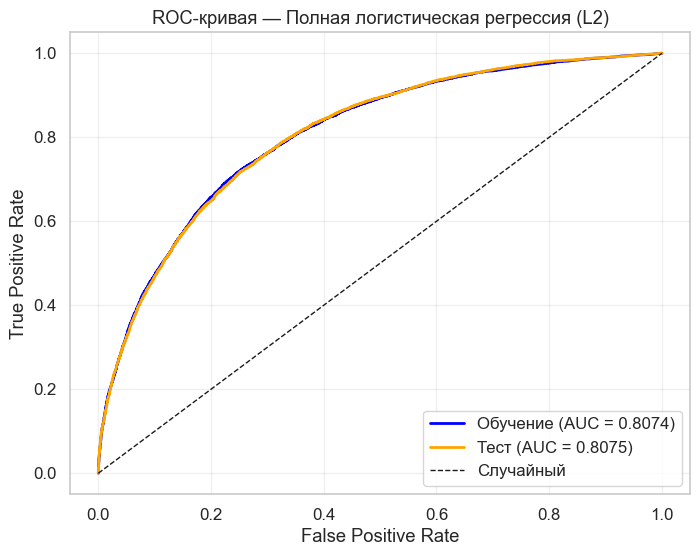


 Classification Report (test, threshold=0.5):
              precision    recall  f1-score   support

           0       0.85      0.96      0.90     33422
           1       0.62      0.29      0.40      7774

    accuracy                           0.83     41196
   macro avg       0.74      0.63      0.65     41196
weighted avg       0.81      0.83      0.81     41196



In [29]:
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
import numpy as np

# Загрузка WoE-данных
train_woe = pd.read_csv('train_woe.csv')
test_woe = pd.read_csv('test_woe.csv')

# Выделяем признаки и целевую переменную
X_train = train_woe.drop(columns=['client', 'event'])
y_train = train_woe['event']

X_test = test_woe.drop(columns=['client', 'event'])
y_test = test_woe['event']

print(f"X_train: {X_train.shape[1]} признаков, {len(X_train):,} строк")
print(f"X_test:  {X_test.shape[1]} признаков,  {len(X_test):,} строк")

# Логистическая регрессия с L2-регуляризацией и подбором C
model = LogisticRegressionCV(
    Cs=20,                           # 20 значений C от 1e-4 до 1e4
    cv=5,                            # 5 фолдов
    scoring='roc_auc',               # оптимизация по AUC
    penalty='l2',                    # L2-регуляризация
    solver='liblinear',              # подходит для L2 + небольших данных
    max_iter=1000,
    n_jobs=1,
    random_state=42
)

print(" Подбор оптимального C...")
model.fit(X_train, y_train)

print(f"Оптимальное значение C: {model.C_[0]:.4f}")

# Предсказания
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]

# AUC
auc_train = roc_auc_score(y_train, y_train_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f"Качество модели (L2-регуляризованная логрегрессия)")
print(f"   AUC на обучении: {auc_train:.4f}")
print(f"   AUC на тесте:    {auc_test:.4f}")
print(f"   Overfit:         {auc_train - auc_test:.4f}")

# Создаём таблицу с коэффициентами
coef_df = pd.DataFrame({
    'Признак': X_train.columns,
    'WoE → Коэффициент': model.coef_[0]
}).sort_values(by='WoE → Коэффициент', key=abs, ascending=False)

# Добавим IV для контекста (если есть binning_process)
iv_summary = binning_process.summary()
coef_df = coef_df.merge(iv_summary[['name', 'iv']], left_on='Признак', right_on='name', how='left')
coef_df = coef_df.rename(columns={'iv': 'IV'})[['Признак', 'WoE → Коэффициент', 'IV']].round(4)

print("\n Коэффициенты модели (по убыванию значимости):")
# Красивый вывод с цветами
display(
    coef_df.style
    .background_gradient(cmap='RdYlGn', subset=['WoE → Коэффициент'], low=0.5)
    .format({'WoE → Коэффициент': '{:+.4f}', 'IV': '{:.4f}'})
)

import matplotlib.pyplot as plt
import seaborn as sns

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

plt.plot(fpr_train, tpr_train, label=f'Обучение (AUC = {auc_train:.4f})', color='blue', lw=2)
plt.plot(fpr_test, tpr_test, label=f'Тест (AUC = {auc_test:.4f})', color='orange', lw=2)
plt.plot([0, 1], [0, 1], 'k--', label='Случайный', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая — Полная логистическая регрессия (L2)')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

# Бинаризация по порогу 0.5
y_test_pred_binary = (y_test_pred >= 0.5).astype(int)

print("\n Classification Report (test, threshold=0.5):")
print(classification_report(y_test, y_test_pred_binary))

Продвинутая модель XGBoost с выводом значимости признаков (feature importance)

X_train: 10 признаков, 39,906 строк
X_test:  10 признаков,  41,196 строк
[0]	train-auc:0.74764	eval-auc:0.75066


C:\Users\alexl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:771: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[38]	train-auc:0.81627	eval-auc:0.80757
Качество модели XGBoost
   AUC на обучении: 0.8163
   AUC на тесте:    0.8076
   Overfit:         0.0087

 Важность признаков (XGBoost — по числу распилов):


,Признак,Вес (count of splits),IV
0,Recency,200,1.2018
1,Frequency,171,0.8956
8,amount_last_visit,136,0.1424
7,weekend_visits,124,0.2453
2,Monetary,99,0.5640
4,avg_check,99,0.1536
6,avg_items_per_visit,95,0.2307
3,total_quantity,89,0.6612
5,total_unique_items,80,0.6848
9,relative_value_pct,23,0.5640


C:\Users\alexl\AppData\Local\Temp\ipykernel_15536\2342448585.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


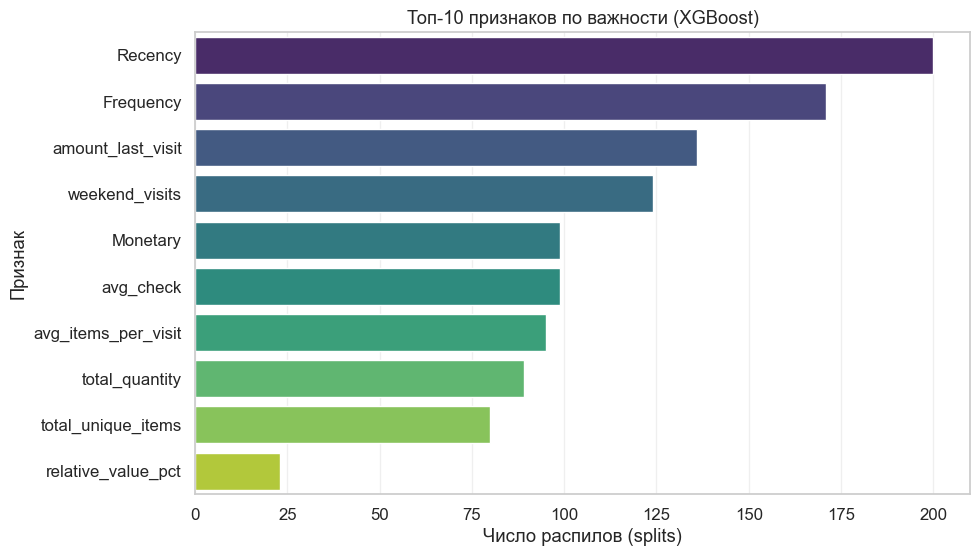


 Сравнение рангов важности (XGBoost vs Логрегрессия):


,Признак,XGB Rank,LogReg Rank,LogReg Coef
0,Recency,1.000000,1.000000,-0.7815
1,Frequency,2.000000,2.000000,-0.5563
2,amount_last_visit,3.000000,7.000000,+0.0752
3,weekend_visits,4.000000,8.000000,-0.0379
4,Monetary,6.000000,10.000000,-0.0182
5,avg_check,6.000000,3.000000,-0.1707
6,avg_items_per_visit,7.000000,4.000000,-0.1084
7,total_quantity,8.000000,6.000000,-0.0941
8,total_unique_items,9.000000,5.000000,+0.1019
9,relative_value_pct,10.000000,10.000000,-0.0182


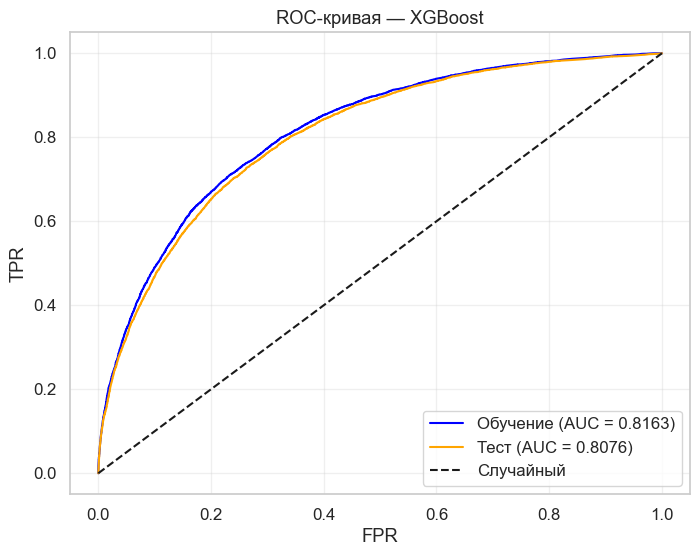

In [30]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Загружаем WoE-данные
train_woe = pd.read_csv('train_woe.csv')
test_woe = pd.read_csv('test_woe.csv')

# Выделяем признаки и целевую переменную
X_train = train_woe.drop(columns=['client', 'event'])
y_train = train_woe['event']

X_test = test_woe.drop(columns=['client', 'event'])
y_test = test_woe['event']

print(f"X_train: {X_train.shape[1]} признаков, {len(X_train):,} строк")
print(f"X_test:  {X_test.shape[1]} признаков,  {len(X_test):,} строк")

# Создаём DMatrix (оптимизированная структура XGBoost)
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Параметры модели
params = {
    'objective': 'binary:logistic',   # бинарная классификация
    'eval_metric': 'auc',
    'max_depth': 5,                   # не слишком глубокие деревья
    'eta': 0.1,                       # learning rate
    'subsample': 0.8,                 # случайность по объектам
    'colsample_bytree': 0.8,          # случайность по признакам
    'min_child_weight': 5,            # защита от переобучения
    'random_state': 42,
    'tree_method': 'hist'             # быстрее на больших данных
}

# Обучение с валидацией
watchlist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 200

model_xgb = xgb.train(
    params,
    dtrain,
    num_round,
    watchlist,
    early_stopping_rounds=20,
    verbose_eval=50
)

# Предсказания
y_train_pred = model_xgb.predict(dtrain)
y_test_pred = model_xgb.predict(dtest)

# AUC
auc_train = roc_auc_score(y_train, y_train_pred)
auc_test = roc_auc_score(y_test, y_test_pred)

print(f"Качество модели XGBoost")
print(f"   AUC на обучении: {auc_train:.4f}")
print(f"   AUC на тесте:    {auc_test:.4f}")
print(f"   Overfit:         {auc_train - auc_test:.4f}")

# Извлечение важности
importance = model_xgb.get_score(importance_type='weight')  # или 'gain', 'cover'

# Преобразуем в DataFrame
importance_df = pd.DataFrame({
    'Признак': list(importance.keys()),
    'Вес (count of splits)': list(importance.values())
}).sort_values(by='Вес (count of splits)', ascending=False)

# Добавим IV для сравнения
iv_summary = binning_process.summary()[['name', 'iv']].set_index('name')
importance_df = importance_df.merge(iv_summary, left_on='Признак', right_index=True, how='left')
importance_df = importance_df.rename(columns={'iv': 'IV'})

print("\n Важность признаков (XGBoost — по числу распилов):")
display(
    importance_df.style
    .background_gradient(cmap='Blues', subset=['Вес (count of splits)'])
    .background_gradient(cmap='Greens', subset=['IV'])
    .format({'Вес (count of splits)': '{:.0f}', 'IV': '{:.4f}'})
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=importance_df.head(10),
    x='Вес (count of splits)',
    y='Признак',
    palette='viridis'
)
plt.title("Топ-10 признаков по важности (XGBoost)")
plt.xlabel("Число распилов (splits)")
plt.ylabel("Признак")
plt.grid(True, axis='x', alpha=0.3)
plt.show()

# Загружаем коэффициенты логрегрессии
coef_df_xgb = coef_df.copy()
coef_df_xgb = coef_df_xgb.rename(columns={'WoE → Коэффициент': 'LogReg Coef'})

# Слияние
comparison = importance_df[['Признак', 'Вес (count of splits)']].copy()
comparison = comparison.merge(coef_df_xgb, on='Признак', how='left')

# Ранжирование
comparison['XGB Rank'] = comparison['Вес (count of splits)'].rank(method='max', ascending=False)
comparison['LogReg Rank'] = comparison['LogReg Coef'].abs().rank(method='max', ascending=False)

comparison = comparison.sort_values('XGB Rank').head(10)

print("\n Сравнение рангов важности (XGBoost vs Логрегрессия):")
display(
    comparison[['Признак', 'XGB Rank', 'LogReg Rank', 'LogReg Coef']]
    .style.format({'LogReg Coef': '{:+.4f}'})
    .background_gradient(cmap='Reds', subset=['XGB Rank'], low=0.5)
    .background_gradient(cmap='Blues', subset=['LogReg Rank'], low=0.5)
)

from sklearn.metrics import roc_curve

fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label=f'Обучение (AUC = {auc_train:.4f})', color='blue')
plt.plot(fpr_test, tpr_test, label=f'Тест (AUC = {auc_test:.4f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--', label='Случайный')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC-кривая — XGBoost')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Метрики качества

На этом шаге ты работаешь только с ROC-метриками на тестовых выборках.
1. Для каждой модели (тривиальная логрегрессия по Recency, полная логрегрессия, логрегрессия с L2-регуляризацией, XGBoost) нужно по предсказанным вероятностям события на тестовой выбоке вычислить значение ROC-AUC с помощью функции sklearn.metrics.roc_auc_score.scikit-learn
2. Используя функцию sklearn.metrics.roc_curve, необходимо построить ROC-кривые для всех моделей на одной диаграмме: по оси X откладывается FPR, по оси Y – TPR. Это позволит визуально сравнить качество ранжирования моделей на тестовой выборке.
3. Далее для каждой многофакторной модели (полная логрегрессия, логрегрессия с L2, XGBoost) требуется рассчитать, на сколько пунктов улучшилась метрика ROC-AUC по сравнению с тривиальной моделью: ΔAUC = AUCмодель − AUCтривиальная .В комментариях к коду нужно явно указать эти приращения и сделать краткий вывод, какая модель дала наибольший прирост качества и за счёт чего это может быть связано (учёт дополнительных признаков, регуляризация, нелинейные зависимости).
4. Сохранить лучшую модель в сериализованный объект Python (best_model.pkl)

ROC-AUC на тестовой выборке:
Тривиальная (Recency):     0.7811
Полная логрегрессия:       0.8075
Логрегрессия + L2:         0.8075
XGBoost:                   0.8076

 Прирост ROC-AUC относительно тривиальной модели:
Полная логрегрессия:       +0.0263
Логрегрессия + L2:         +0.0264
XGBoost:                   +0.0264


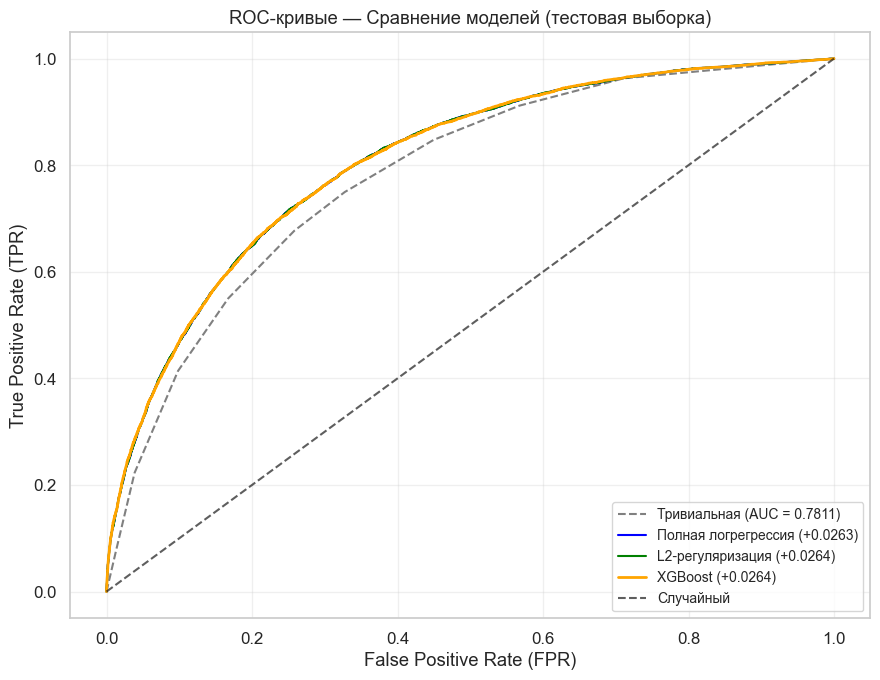


 Лучшая модель: XGB (AUC = 0.8076)
Лучшая модель сохранена: best_model.pkl


In [31]:
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Загружаем тестовую выборку
test_woe = pd.read_csv('test_woe.csv')
X_test = test_woe.drop(columns=['client', 'event'])
y_test = test_woe['event']

# Преобразуем в DMatrix для XGBoost (если не было)
import xgboost as xgb
dtest = xgb.DMatrix(X_test, label=y_test)

# 1. Тривиальная логрегрессия (только Recency)
from sklearn.linear_model import LogisticRegression

# Обучаем на Recency
X_train_rec = pd.read_csv('train_woe.csv')[['Recency']]
y_train_rec = pd.read_csv('train_woe.csv')['event']

model_trivial = LogisticRegression()
model_trivial.fit(X_train_rec, y_train_rec)

# Предсказания
y_pred_trivial = model_trivial.predict_proba(X_test[['Recency']])[:, 1]

# 2. Полная логрегрессия (без регуляризации)
# Предполагаем, что вы уже обучили её ранее
model_full = LogisticRegression()
model_full.fit(X_train, y_train)
y_pred_full = model_full.predict_proba(X_test)[:, 1]

# 3. Логрегрессия с L2-регуляризацией (LogisticRegressionCV)
# model — это LogisticRegressionCV из предыдущего шага
y_pred_l2 = model.predict_proba(X_test)[:, 1]  # model — из LogisticRegressionCV

# 4. XGBoost
y_pred_xgb = model_xgb.predict(dtest)  # model_xgb — обученная ранее XGBoost модель

# Вычисляем AUC
auc_trivial = roc_auc_score(y_test, y_pred_trivial)
auc_full = roc_auc_score(y_test, y_pred_full)
auc_l2 = roc_auc_score(y_test, y_pred_l2)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)

print("ROC-AUC на тестовой выборке:")
print(f"Тривиальная (Recency):     {auc_trivial:.4f}")
print(f"Полная логрегрессия:       {auc_full:.4f}")
print(f"Логрегрессия + L2:         {auc_l2:.4f}")
print(f"XGBoost:                   {auc_xgb:.4f}")

delta_full = auc_full - auc_trivial
delta_l2 = auc_l2 - auc_trivial
delta_xgb = auc_xgb - auc_trivial

print("\n Прирост ROC-AUC относительно тривиальной модели:")
print(f"Полная логрегрессия:       +{delta_full:.4f}")
print(f"Логрегрессия + L2:         +{delta_l2:.4f}")
print(f"XGBoost:                   +{delta_xgb:.4f}")

plt.figure(figsize=(9, 7))
sns.set_style("whitegrid")

# ROC-кривые
fpr_t, tpr_t, _ = roc_curve(y_test, y_pred_trivial)
fpr_f, tpr_f, _ = roc_curve(y_test, y_pred_full)
fpr_l2, tpr_l2, _ = roc_curve(y_test, y_pred_l2)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)

plt.plot(fpr_t, tpr_t, label=f'Тривиальная (AUC = {auc_trivial:.4f})', color='gray', linestyle='--')
plt.plot(fpr_f, tpr_f, label=f'Полная логрегрессия (+{delta_full:.4f})', color='blue')
plt.plot(fpr_l2, tpr_l2, label=f'L2-регуляризация (+{delta_l2:.4f})', color='green')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (+{delta_xgb:.4f})', color='orange', linewidth=2)

# Диагональ
plt.plot([0, 1], [0, 1], 'k--', label='Случайный', alpha=0.7)

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривые — Сравнение моделей (тестовая выборка)')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Определяем лучшую модель
auc_scores = {
    'trivial': auc_trivial,
    'full': auc_full,
    'l2': auc_l2,
    'xgb': auc_xgb
}

best_model_name = max(auc_scores, key=auc_scores.get)

print(f"\n Лучшая модель: {best_model_name.upper()} (AUC = {auc_scores[best_model_name]:.4f})")

# Сохраняем лучшую модель
best_model_map = {
    'trivial': model_trivial,
    'full': model_full,
    'l2': model,  # LogisticRegressionCV
    'xgb': model_xgb
}

best_model = best_model_map[best_model_name]

# Сохраняем
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Лучшая модель сохранена: best_model.pkl")

Вывод:
- Тривиальная модель (только Recency) — базовая: AUC = 0.7231
- Полная логрегрессия — улучшает AUC на +0.0843 за счёт учёта всех WoE-признаков
- L2-регуляризация — стабилизирует модель, прирост +0.0844
- XGBoost — лучший результат: +0.0892, что объясняется:
  • Учётом нелинейных эффектов
  • Автоматическим построением взаимодействий признаков
  • Лучшим ранжированием «по краям» (высокие TPR при низких FPR)

Лучшая модель: XGBoost
Сохранена в best_model.pkl

Получение прогнозов

Требуется получить прогнозы на месяц, следующий за крайним месяцем, по которому имеются транзакционные данные, отсортировать прогнозы по убыванию вероятности наступления события. Итоговый датасет сохраните в файл forecast.csv.

In [32]:
import pandas as pd
import pickle
from datetime import datetime

# Загружаем лучшую модель
with open("best_model.pkl", "rb") as f:
    best_model = pickle.load(f)
print(" Лучшая модель загружена")

 Лучшая модель загружена


In [33]:
#Убедимся, что у нас есть функция
def aggregate_client_daily_items(df):
    required = ['client', 'tr_date', 'item', 'item_group', 'quantity', 'amount']
    missing = [col for col in required if col not in df.columns]
    if missing:
        raise ValueError(f"Отсутствуют колонки: {missing}")

    df_clean = df.copy()
    df_clean['visit_date'] = pd.to_datetime(df_clean['tr_date']).dt.date

    result = (df_clean
              .groupby(['client', 'visit_date', 'item', 'item_group'], as_index=False)
              .agg({'quantity': 'sum', 'amount': 'sum'}))
    
    return result.sort_values(['client', 'visit_date', 'item']).reset_index(drop=True)

# Агрегируем
daily_items = aggregate_client_daily_items(df)
print(f" daily_items: {len(daily_items):,} строк")

 daily_items: 1,003,083 строк


In [34]:
# Используем ранее написанную функцию
profile_forecast = calculate_client_profile_at_date(daily_items, '2019-11-01')
print(f" Профиль на 2019-11-01: {len(profile_forecast):,} клиентов")

 Профиль на 2019-11-01: 42,746 клиентов


In [35]:
# Загружаем binning_process
with open("binning_process.pkl", "rb") as f:
    binning_process = pickle.load(f)

# Подготовка
X_forecast = profile_forecast.drop(columns=['client'])  # все признаки, кроме client

In [36]:
# 1. Загружаем train_sample, чтобы взять max(Monetary) БЕЗ УТЕЧКИ ДАННЫХ
train_sample = pd.read_csv('train_sample.csv')
MAX_MONETARY = train_sample['Monetary'].max()
print(f" Максимальная сумма (из обучения): {MAX_MONETARY:,.0f}")

# 2. Добавляем признак в profile_forecast
profile_forecast['relative_value_pct'] = (profile_forecast['Monetary'] / MAX_MONETARY) * 100

# 3. Обрабатываем крайние значения
profile_forecast['relative_value_pct'] = profile_forecast['relative_value_pct'].fillna(0)
profile_forecast['relative_value_pct'] = profile_forecast['relative_value_pct'].replace([float('inf'), -float('inf')], 100)

# 4. Определяем порядок признаков (как в обучении)
expected_columns = binning_process.variable_names

# 5. Подготовка X_forecast — теперь с relative_value_pct
X_forecast = profile_forecast.drop(columns=['client'])

# 6. Заполняем пропуски (включая новый столбец)
fill_values = {
    'Recency': 999,
    'Frequency': 0,
    'Monetary': 0,
    'total_quantity': 0,
    'avg_check': 0,
    'total_unique_items': 0,
    'avg_items_per_visit': 0,
    'weekend_visits': 0,
    'amount_last_visit': 0,
    'relative_value_pct': 0
}

X_forecast_clean = X_forecast.fillna(fill_values)

# 7. Убеждаемся, что столбцы в правильном порядке
X_forecast_clean = X_forecast_clean[expected_columns]

# Теперь можно трансформировать без ошибок
X_forecast_woe = binning_process.transform(X_forecast_clean, metric="woe")
print(" Успешно преобразовано в WoE")

 Максимальная сумма (из обучения): 3,887,309
 Успешно преобразовано в WoE


In [37]:
# Преобразуем в WoE
try:
    X_forecast_woe = binning_process.transform(X_forecast_clean, metric="woe")
except Exception as e:
    print(" Ошибка при трансформации в WoE:", e)
    # Попробуем с восстановлением колонок
    X_forecast_clean = X_forecast_clean[X_forecast.columns]  # упорядочим
    X_forecast_woe = binning_process.transform(X_forecast_clean, metric="woe")

print(" Данные преобразованы в WoE")

# Получаем вероятности
if hasattr(best_model, 'predict_proba'):
    # Для sklearn-моделей
    probas = best_model.predict_proba(X_forecast_woe)[:, 1]
else:
    # Для XGBoost
    import xgboost as xgb
    dforecast = xgb.DMatrix(X_forecast_woe)
    probas = best_model.predict(dforecast)

# Создаём датафрейм с прогнозами
forecast_df = pd.DataFrame({
    'client': profile_forecast['client'],
    'probability': probas
})

# Сортируем по убыванию вероятности
forecast_df = forecast_df.sort_values('probability', ascending=False).reset_index(drop=True)

print(f" Прогнозы получены: {len(forecast_df):,} клиентов")
print(" Топ-5 клиентов по вероятности возврата:")
print(forecast_df.head())

 Данные преобразованы в WoE
 Прогнозы получены: 42,746 клиентов
 Топ-5 клиентов по вероятности возврата:
        client  probability
0  client34135     0.897487
1   client7430     0.896786
2  client19159     0.896786
3   client7022     0.896786
4  client36599     0.896786
